# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the project repository.

---
**The Writeup**
The writeup will be the primary output you submit (along with your code of course).

Within the project repository, there is a writeup template that you can use as a starting point for your project writeup.

A great writeup should include the rubric points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where appropriate) and links to other supporting documents or external references. You should also include images in your writeup to illustrate how your code works.

All that said, please be concise! We're not looking for you to write a book, just a brief description of how you passed each rubric point, and references to the relevant code :)

You are not required to use Markdown for your writeup. If you use another method, please just submit a PDF of your writeup.

**The Code**
Your code should stand on its own as readable material. Explain in code comments, as well as in your writeup, how your code works and why you wrote it that way.

Make it easy for a reviewer to understand your code.

You are more than welcome to use code from the lesson. But if you copy something explain how it works and why you used it.

**What It Takes to Pass**
Read the project rubric for details on the requirements for a passing submission.

Your writeup should include each rubric point and your description of how you addressed that point in your submission. The project repo provides an example template for your writeup.

There is no starter code provided, but you are welcome to use code from the lesson and quizzes as you like. You may complete the project in a Jupyter notebook, but it's not required. Feel free to build it as a standalone project.

To help the reviewer evaluate your project, please save example images from each stage of your pipeline to the output_images folder and provide in your writeup a description of each image. Please also save your output video and include it with your submission.

**Evaluation**
Once you have completed your project, double check the Project Rubric to make sure you have addressed all the rubric points. Your project will be evaluated by a Udacity reviewer according to that same rubric.

Your project must "meet specifications" in each category in order for your submission to pass. If you are happy with your submission, then you are ready to submit! If you see room for improvement in any category in which you do not meet specifications, keep working!

**Submission**
What to Include
Include a zipped file with your:

**writeup**
code (or a Jupyter notebook)
example output images
output video
Alternatively, you may submit a link to your GitHub repo for the project.

In either case, remember to include example images for each stage of your pipeline and your final output video in your submission.

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
# Code Block 01
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Reading an Image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


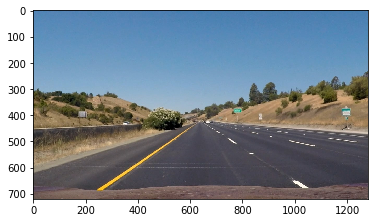

In [2]:
# Code Block 02
#reading in an image
image = mpimg.imread('straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
# Code Block 03
"""
This functions are mostly inherited for project 1 with some additionals
"""

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def drawline_alphab(lines, img, boty, topy):
    '''
    This function draws `lines` with `color` and `thickness`
    based on its slope and the y-intercept.
    They start from the bottom of the image seted (boty) to the top
    (topy).
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    '''
    # An empty canvas is prepared based on the original image dimensions
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lanes = []
    for line in lines:
        if line[0]!=math.pi/4:
            m = math.tan(line[0])
        else:
            # In case of a vertical line the max slope is set to 1000
            m = 1000
        # based on the coordinates and the top values, the X,Y points are
        # calculated
        Y1 = topy
        X1 = (Y1-line[1]) / m
        Y0 = boty
        X0 = (Y0-line[1]) / m
        lane1=[[[int(X0), int(Y0), int(X1), int(Y1)]]]
        lanes+=lane1
    # Now the lines are draw in the canvas
    draw_lines(line_img, lanes, color=[255, 0, 0], thickness=8)
    return weighted_img(line_img, img)

def line_length(V):
    '''
    This function receive the two coordinates of a line and
    return its lengths
    '''
    x0 = line[0,0]
    y0 = line[0,1]
    x1 = line[0,2]
    y1 = line[0,3]
    x = x1 - x0
    y = y1 - y0
    
    return math.sqrt(x**2+y**2)

def weigthed_sum(Lines):
    '''
    This funtion calculates the weighted sum of lines stored in alpha angle of inclination
    B as its y-intercept and L its lengths.
    Returns an [int a, int b] with the total sum of the angle and the y-intercept
    '''
    totalA = 0
    totalB = 0
    total_length = 0
    for a, b, l in Lines:
        totalA += a*l
        totalB += b*l
        total_length+=l
    totalA/=total_length
    totalB/=total_length

    return [totalA, totalB]



def cal_undistort(img, mtx, dist):
    """
    This function apply the calibration matrix
    of a camera, previously calculated to a 
    particular image to correct the distortion
    """
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undist = np.copy(dst)
    return undist

def warp(img, src = np.float32(
        [[622.491, 431.432],
         [654.442, 431.432],
         [1040.87, 676.387],
         [265.789, 676.387]])):
    """
    This function creates a warp image to a
    default first plane from a quadrilateral
    Polygon src
    """
    img_size = (img.shape[1], img.shape[0])
    
    # Road perspective lane lines
    #src = np.float32(
    #    [[622.491, 431.432],
    #     [654.442, 431.432],
    #     [1040.87, 676.387],
    #     [265.789, 676.387]])
    # Warped desired rectangled
    dst = np.float32(
        [[350,0],#427
         [853,0],
         [853,720],
         [350,720]])#427

    # Compute M, the perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    
    # Created the warped Image
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_NEAREST)
    
    return warped

def unwarp(img, src = np.float32(
    """
    This is the inverse function
    of warp
    """
        [[622.491, 431.432],
         [654.442, 431.432],
         [1040.87, 676.387],
         [265.789, 676.387]])):
    
    img_size = (img.shape[1], img.shape[0])
    
    # Road perspective lane lines
    #src = np.float32(
    #    [[622.491, 431.432],
    #     [654.442, 431.432],
    #     [1040.87, 676.387],
    #     [265.789, 676.387]])
    # Warped desired rectangled
    dst = np.float32(
        [[350,0],
         [853,0],
         [853,720],
         [350,720]])

    # Compute M, the perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Created the warped Image
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags = cv2.INTER_NEAREST)
    return unwarped

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
# Code Block 04
# Lets test our file dirs for camera calibration
import os
os.listdir("camera_cal/")

['calibration14.jpg',
 'calibration4.jpg',
 'calibration7.jpg',
 'calibration16.jpg',
 'calibration9.jpg',
 'calibration15.jpg',
 'calibration6.jpg',
 'calibration20.jpg',
 'calibration11.jpg',
 'calibration13.jpg',
 'calibration3.jpg',
 'calibration8.jpg',
 'calibration12.jpg',
 'calibration19.jpg',
 'calibration18.jpg',
 'calibration2.jpg',
 'calibration5.jpg',
 'calibration10.jpg',
 'calibration17.jpg',
 'calibration1.jpg']

It's important to know we are able to reach the test files first in order to try the pipeline

In [5]:
# Code Block 05
# And our file dirs for the pipeline test
os.listdir("test_images/")

['test3.jpg',
 'test5.jpg',
 'straight_lines2.jpg',
 'test6.jpg',
 'straight_lines1.jpg',
 'test4.jpg',
 'test1.jpg',
 'test2.jpg']

## Camera Calibration

To test the files are correctly loaded lets print an image for camera calibration

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


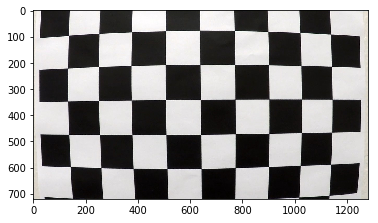

In [5]:
# Code Block 06
#reading in an image
camcalimg = mpimg.imread('camera_cal/calibration1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(camcalimg)

Now that the image is loaded, we need to transform it to grayscale

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280)


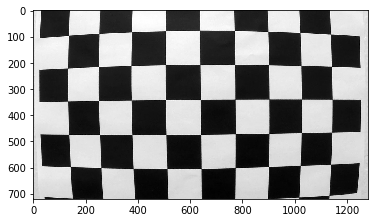

In [6]:
# Code Block 07
# The image its transformed to grayscale
gray= []
gray = cv2.cvtColor(camcalimg,cv2.COLOR_RGB2GRAY)
print('This image is:', type(gray), 'with dimesions:', gray.shape)
plt.imshow(gray,  cmap='gray')

## Frist we'll import a test image

With the image in grayscale we can now detect the corners and the identify them in the color image

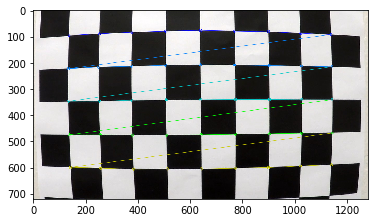

In [11]:
# Code Block 08
objpoints = []
imgpoints = []

objp = np.zeros((5*9,3),np.float)

objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)

ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
    calcorner = camcalimg.copy()
    cv2.drawChessboardCorners(calcorner, (9,5), corners, ret)
    plt.imshow(calcorner)
else:
    print("Problem finding corners")


# It's worth noting that the first image have less point availble than the rest so
# it needs to be tested with a different parameters

## Now that the pipeline worked on an image, It's time to use it for the rest

We need to load the entire set of files in the camera_cal dir

In [7]:
# Code Block 09
# Import all the image files to calibrate the camera
import glob
images = glob.glob("camera_cal/*.jpg")
for i in range(20):
    print(str(i)+": "+images[i])

0: camera_cal/calibration14.jpg
1: camera_cal/calibration4.jpg
2: camera_cal/calibration7.jpg
3: camera_cal/calibration16.jpg
4: camera_cal/calibration9.jpg
5: camera_cal/calibration15.jpg
6: camera_cal/calibration6.jpg
7: camera_cal/calibration20.jpg
8: camera_cal/calibration11.jpg
9: camera_cal/calibration13.jpg
10: camera_cal/calibration3.jpg
11: camera_cal/calibration8.jpg
12: camera_cal/calibration12.jpg
13: camera_cal/calibration19.jpg
14: camera_cal/calibration18.jpg
15: camera_cal/calibration2.jpg
16: camera_cal/calibration5.jpg
17: camera_cal/calibration10.jpg
18: camera_cal/calibration17.jpg
19: camera_cal/calibration1.jpg


Now we detect every corner on every image and detect the corners, storing the points in imgpoints

Loading Images...
camera_cal/calibration14.jpg
camera_cal/calibration4.jpg
camera_cal/calibration7.jpg
camera_cal/calibration16.jpg
camera_cal/calibration9.jpg
camera_cal/calibration15.jpg
camera_cal/calibration6.jpg
camera_cal/calibration20.jpg
camera_cal/calibration11.jpg
camera_cal/calibration13.jpg
camera_cal/calibration3.jpg
camera_cal/calibration8.jpg
camera_cal/calibration12.jpg
camera_cal/calibration19.jpg
camera_cal/calibration18.jpg
camera_cal/calibration2.jpg
camera_cal/calibration5.jpg
camera_cal/calibration10.jpg
camera_cal/calibration17.jpg
Images Loaded.


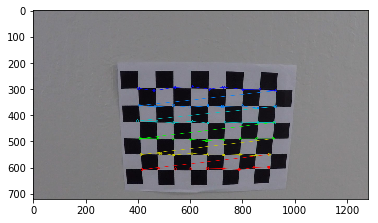

In [9]:
# Code Block 10
objpoints = []
imgpoints = []
objp = np.zeros((6*9,3),np.float)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

print("Loading Images...")
for i in range(19):
    fname = images[i]
    print(fname)
    img = mpimg.imread(fname)
    
    tempgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(tempgray, (9,6), None)
    
    if ret == True:

        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners.astype('float32'))
        objpoints.append(objp.astype('float32'))
        
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
print("Images Loaded.")
# To have the satisfaction of all our data ready to calibrate, the last detection image is showed
plt.imshow(img)

## Camera Calibration

Having our data ready, we start the calibration process properly said

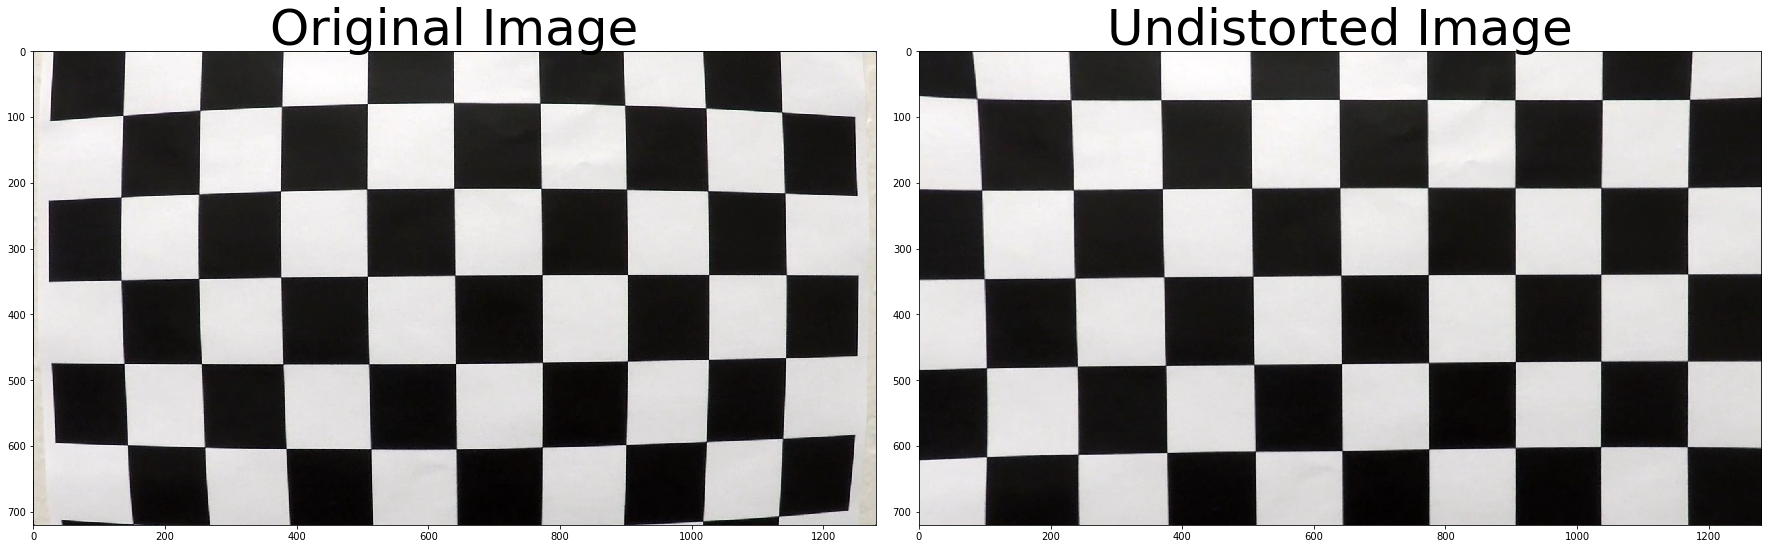

In [10]:
# Code Block 11
# The camera parameters are calculated
img = mpimg.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# After obtain the calibration parameters, we try with one of the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Saving Point

In [13]:
# Code Block 12
# Save the camera data into a pickle file.
import pickle
with open("camera.pickle","wb") as f:
        pickle.dump( mtx, f)
        pickle.dump( dist, f)



## Loading Point

In [14]:
# Code Block 13
# The camera data is loaded to be tested
with open("camera.pickle", "rb") as f:
    mtx = pickle.load(f)
    dist = pickle.load(f)

### Checking parameters

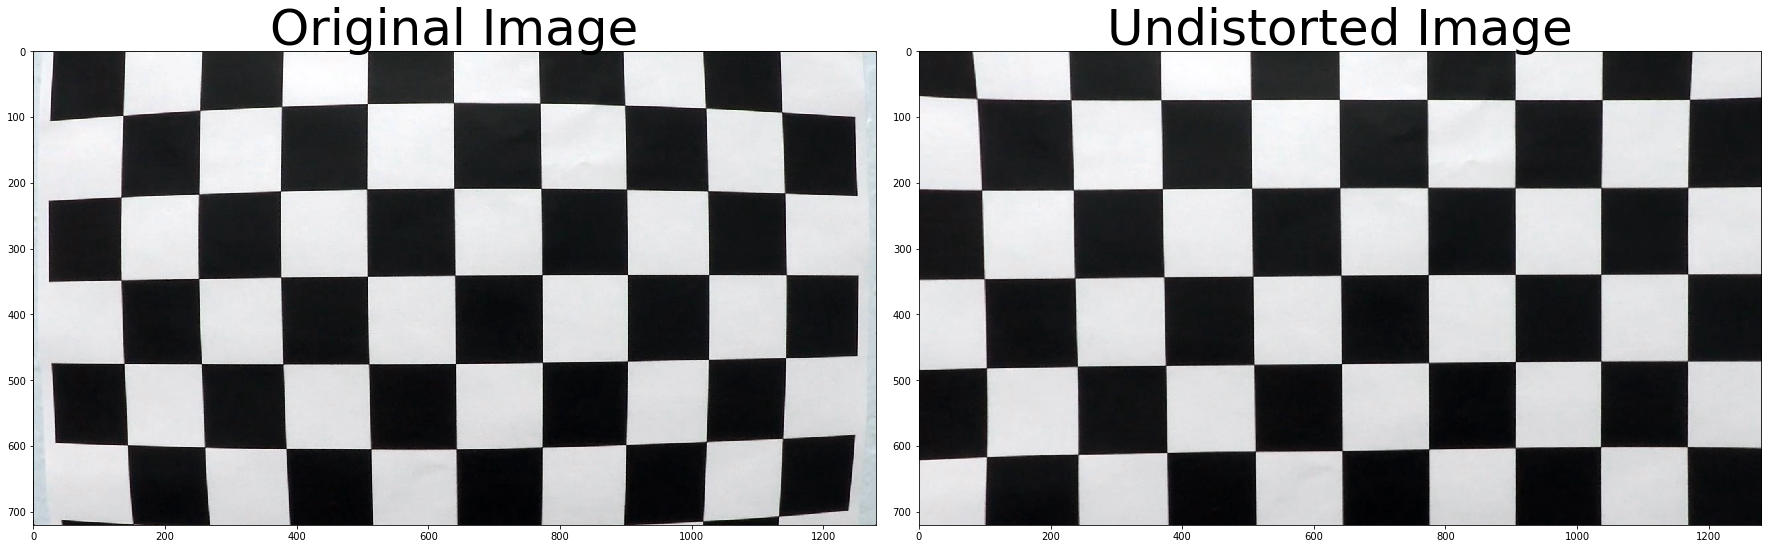

In [15]:
# Code Block 14
# The data loaded is tested with an image and compared
img = cv2.imread('camera_cal/calibration1.jpg')

undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

### First, lets transform the image to Grayscale
The pipeline is built. It will draw lane lines on the test images then saves them.

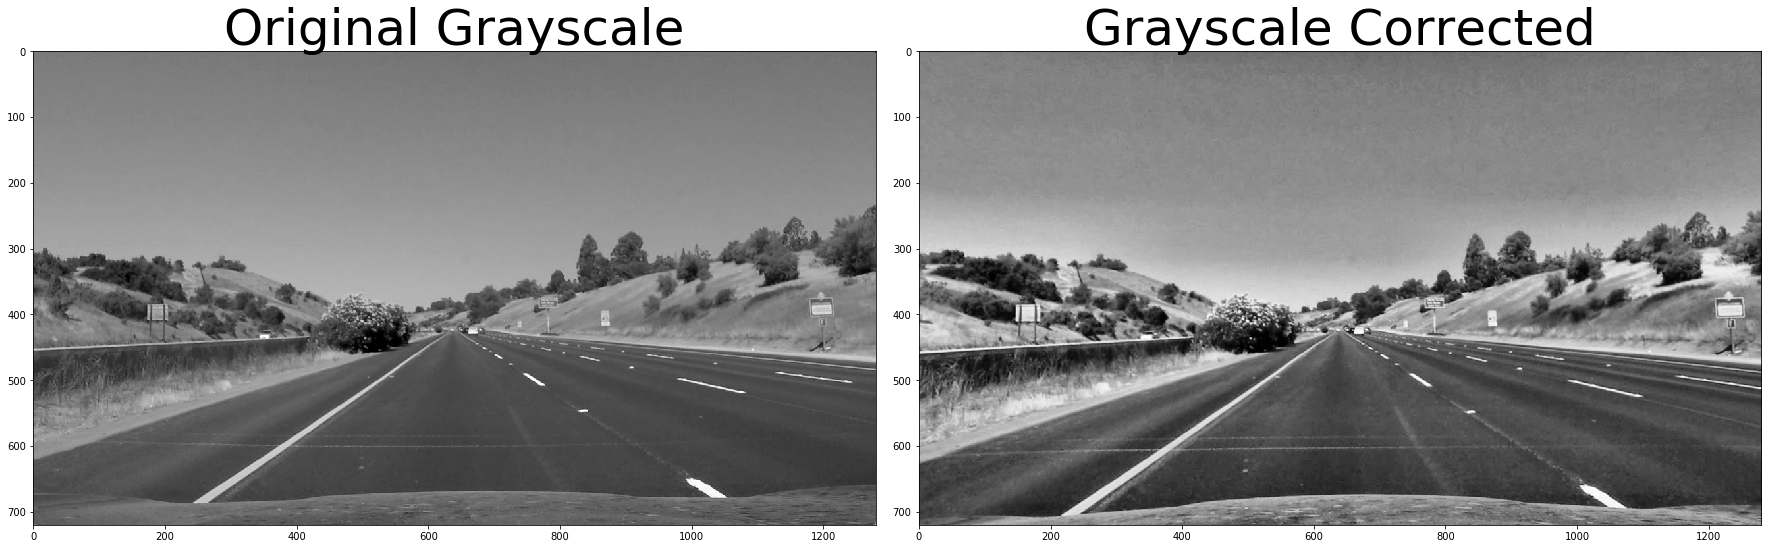

In [308]:
# Code Block 15
# The image is loaded to start the pipeline
image = mpimg.imread('./test_images/straight_lines1.jpg')
gray = grayscale(image)
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_contrasted = clahe.apply(gray)
# The image is corrected with the camera parameters previously calculated
imgcorr = cal_undistort(gray_contrasted, mtx, dist)

# Then compared for demostrative purpose
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray, cmap='gray')
ax1.set_title('Original Grayscale', fontsize=50)
ax2.imshow(imgcorr, cmap='gray')
ax2.set_title('Grayscale Corrected', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Now an image is created with the Red and Green channel, discarting the Blue channel in order to obtain 

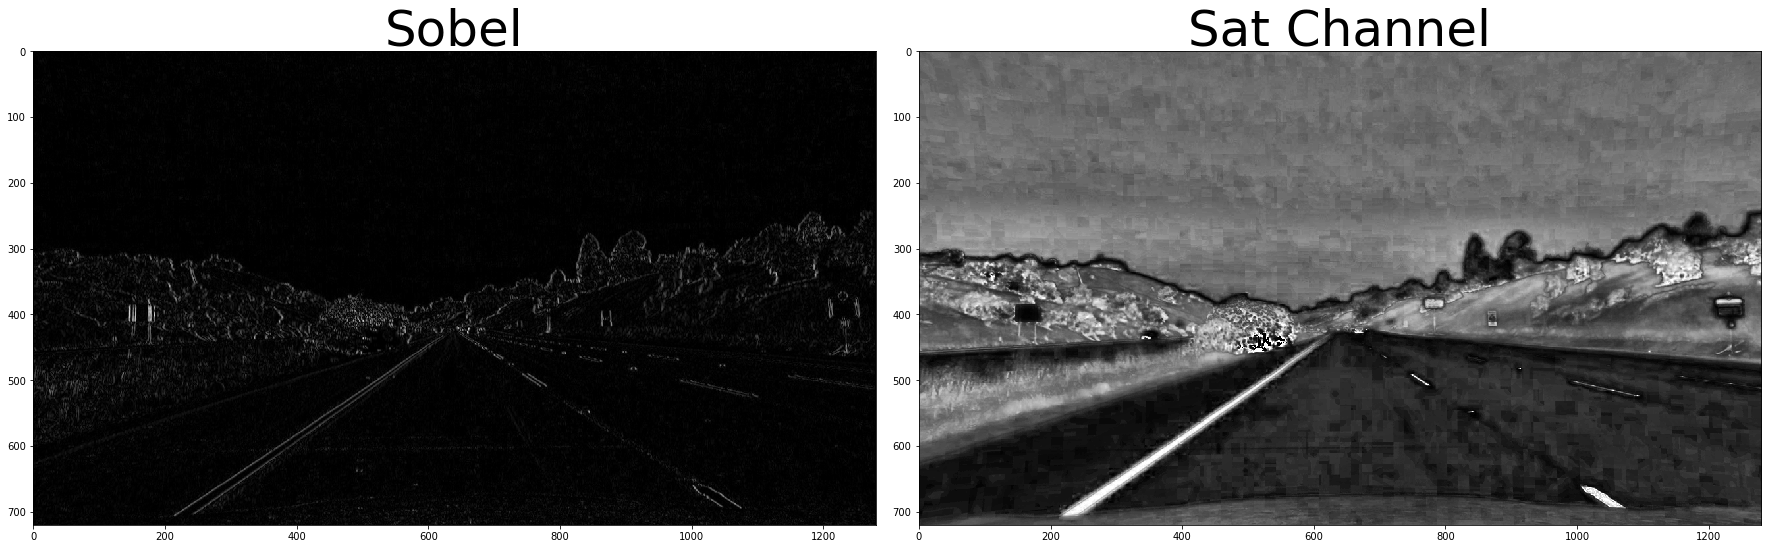

In [309]:
# Code Block 16
imgcolorcorr = cal_undistort(image, mtx, dist)
hls = cv2.cvtColor(imgcolorcorr, cv2.COLOR_RGB2HLS)
saturation = hls[:,:,2]
saturation = clahe.apply(saturation)

R = imgcolorcorr[:,:,0]
G = imgcolorcorr[:,:,1]
B = imgcolorcorr[:,:,2]

# Coef based on Rec. 709
R = clahe.apply(R)
G = clahe.apply(G)
RG = 0.213*R+0.715*G

# Sobel x
sobelx = cv2.Sobel(RG, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))


# The results are showed bellow
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(scaled_sobel, cmap='gray')
ax1.set_title('Sobel', fontsize=50)
ax2.imshow(saturation, cmap='gray')
ax2.set_title('Sat Channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

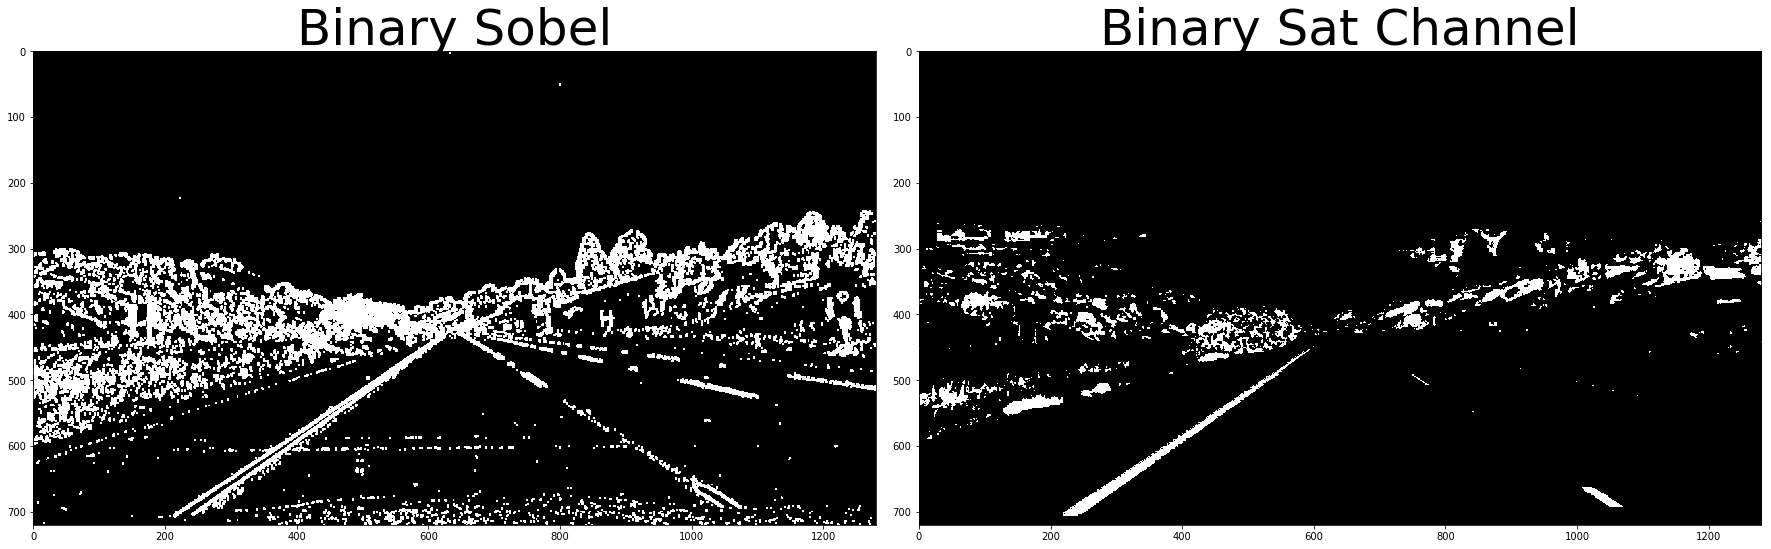

In [310]:
# Code Block 17
# Threshold gradient of the yellow channel
thresh_min = 20
thresh_max = 255
sobelxbinary = np.zeros_like(scaled_sobel)
sobelxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

sxbinary = cv2.morphologyEx(sobelxbinary, cv2.MORPH_DILATE, kernel)

# Threshold color channel and binarization of the Sat channel
tsaturation = saturation/np.max(saturation)*255
s_thresh_min = 155
s_thresh_max = 255
s_binary = np.zeros_like(saturation)
s_binary[(tsaturation >= s_thresh_min) & (tsaturation <= s_thresh_max)] = 1

# The result of both binary images can be observed bellow
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sxbinary, cmap='gray')
ax1.set_title('Binary Sobel', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('Binary Sat Channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

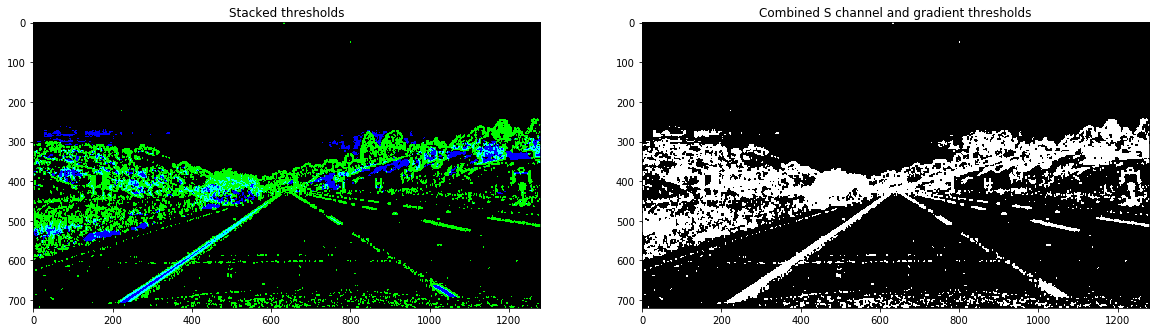

In [311]:
# Code Block 18
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), 255*sxbinary, 255*s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# The binary image is processed to try reduce black spaces with close
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
final_binary = cv2.morphologyEx(combined_binary, cv2.MORPH_CLOSE, kernel)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(final_binary, cmap='gray')

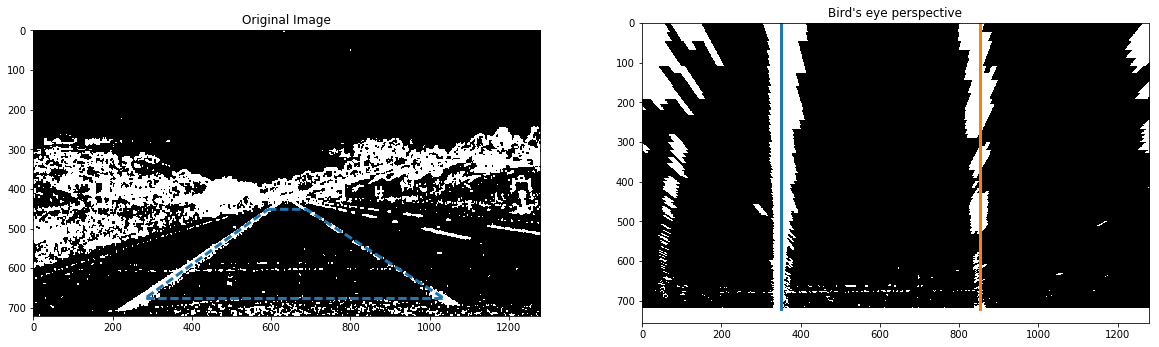

In [312]:
# Code Block 19
tdrift = -18                  # Drift in the top of the trapezoid
bdrift = 28                   # Drift in the body of the trapezoid
ydrif = 20                    # Drift in y direction of the top of the trapezoid
xctr = -12                    # Center of the trapezoid
top = 654.442 - 622.491+67-2  # Start point of the trapezoid
base = 1040.87 - 265.789 - 20 # Start point of the trapezoid
src = np.float32([[622.491+xctr+tdrift, 431.432+ydrif],
         [622.491+top+xctr+tdrift, 431.432+ydrif],
         [265.789+base+xctr+bdrift, 676.387],
         [265.789+xctr+bdrift, 676.387]])
warped_binary = warp(final_binary, src)
vertices = np.append(src,[src[0]], axis = 0)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(final_binary, cmap='gray')
ax1.plot(vertices[:,0], vertices[:,1], ls='dashed', lw=3)

ax2.set_title("Bird's eye perspective")
ax2.imshow(warped_binary, cmap='gray')
ax2.plot([350,350],[0,720], lw=3)
ax2.plot([853,853],[0,720], lw=3)

27313.6029011 m 1090.76896043 m


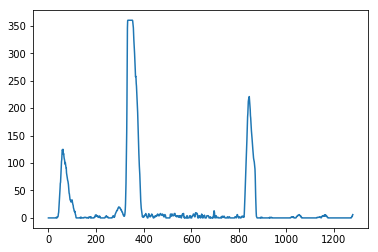

In [313]:
# Code Block 20
out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
x0 = out_img.shape[0]
histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[midpoint//3:midpoint])+midpoint//3
rightx_base = np.argmax(histogram[midpoint:5*midpoint//3]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped_binary.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
left_dev = []
right_dev = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_binary.shape[0] - (window+1)*window_height
    win_y_high = warped_binary.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # Evaluate the dispersion in the window
    left_dev = np.append(left_dev, np.std(nonzerox[good_left_inds]))
    right_dev = np.append(right_dev, np.std(nonzerox[good_right_inds]))

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Evaluate the dispersion of the points
displeft = np.nansum(left_dev)/np.sqrt(np.count_nonzero(left_dev))
dispright = np.nansum(right_dev)/np.sqrt(np.count_nonzero(right_dev))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 28/720 # meters per pixel in y dimension
xm_per_pix = 3.7/503 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*x0*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*x0*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


(720, 0)

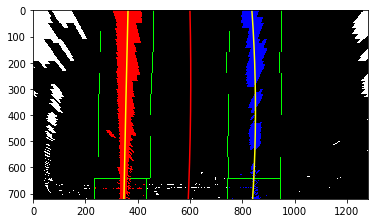

In [314]:
# Code Block 21
# Generate x and y values for plotting
ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
center_fitx = (right_fit[0]+left_fit[0])/2*ploty**2 + (left_fit[1]+right_fit[1])/2*ploty + right_fit[2]/2+left_fit[2]/2
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Showing the resultant curve
plt.imshow(out_img/np.max(out_img))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.plot(center_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

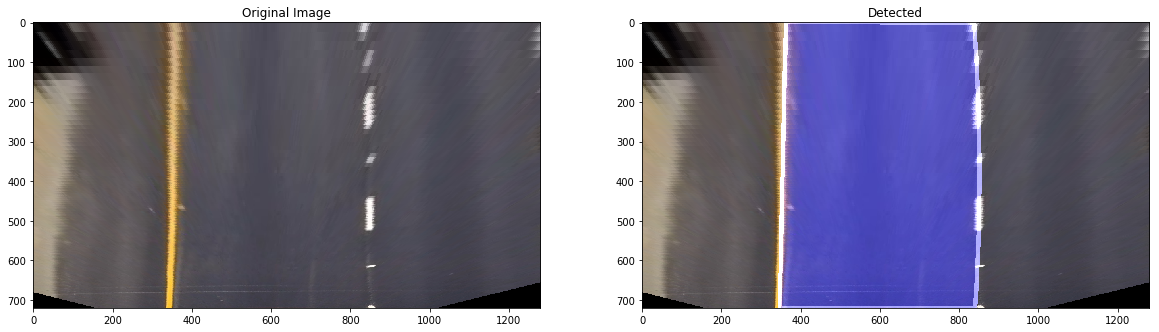

In [315]:
# Code Block 22
F=[] # A container of the points for the border of the lanes
G=[] # A container of the points for lane itself
for i in range(np.shape(ploty)[0]):
    f = [left_fitx[i], ploty[i]]
    F.append(f)
for i in range(np.shape(ploty)[0]-1,0,-1):
    g = [right_fitx[i], ploty[i]]
    F.append(g)
F.append([left_fitx[0], ploty[0]]) # The last point to close the figure
F=np.array([F]).astype('int32')
G=np.array([G]).astype('int32')

linemask = np.zeros_like(imgcolorcorr)
linemask = cv2.fillPoly(linemask, [F], (0,0,128))
linemask = cv2.polylines(linemask, [F], True, (128,128,255),10)

warped_color = warp(imgcolorcorr, src)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(warped_color)

ax2.set_title("Detected")
ax2.imshow(weighted_img(warped_color,linemask))


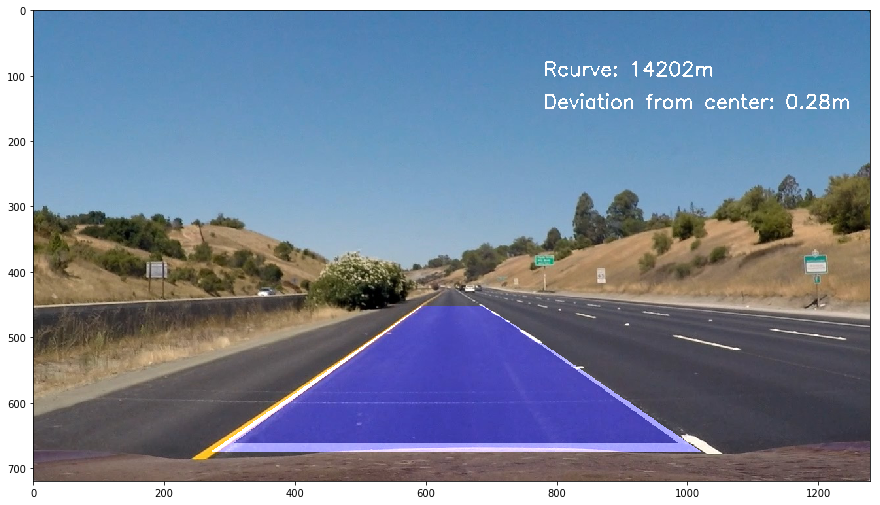

In [324]:
# Code Block 23
overlay=unwarp(linemask,src)

ym_per_pix = 28/720 # meters per pixel in y dimension
xm_per_pix = 3.7/350 # meters per pixel in x dimension

#calculate the curvature
A = (right_fit[0] + left_fit[0])/2
B = (right_fit[1] + left_fit[1])/2
C = (right_fit[2] + left_fit[2])/2
xp = 2*A*x0 + B
xpp = 2*A
r = ((1+xp**2)**1.5)/xpp
# Write the curvature radio
font = cv2.FONT_HERSHEY_SIMPLEX
Rcurve = left_curverad/2 + right_curverad/2
cv2.putText(overlay,'Rcurve: '+str(np.int32(Rcurve))+'m',(780,100), font, 1,(255,255,255),2)

x0 = overlay.shape[1]
y0 = overlay.shape[0]
# Find the center of the lane
center_fit_cr = left_fit_cr/2 + right_fit_cr/2
lane.center = center_fit_cr[0]*(x0*ym_per_pix)**2 + center_fit_cr[1]*(x0*ym_per_pix) + center_fit_cr[2]
# Write the deviation from the center
lane_deviation = lane.center - y0/2*xm_per_pix
cv2.putText(overlay,'Deviation from center: '+str('{0:.2f}'.format(lane_deviation))+'m',(780,150), font, 1,(255,255,255),2)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(weighted_img(image,overlay), interpolation='nearest')

## With the pipeline done, let's arm it

### First, divide and conquer

In [49]:
# Code Block 24
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import pickle
import glob
%matplotlib inline

In [263]:
# Code Block 25
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # Average x values of the fitted line over the last n iterations
        self.bestx = None   
        # Polynomial coefficients averaged over the last n iterations
        self.best_fitL = None
        self.best_fitR = None
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # Radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # Previous start position
        self.line_base_pos = None 
        # Difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # X values for detected line pixels
        self.allx = None  
        # Y values for detected line pixels
        self.ally = None
        # The last center
        self.center = None

In [50]:
# Code Block 26
def camera_correction(img):
    """
    This function use the camera parameters stored in camera.pickle
    to the image 'img'
    """
    with open("camera.pickle","wb") as f:
        pickle.dump( mtx, f)
        pickle.dump( dist, f)
    corrected_img = cal_undistort(img, mtx, dist)
    return corrected_img

In [227]:
# Code Block 27
def image_binarization(image):
	"""
	This functions creates a binary image based on the saturation channel
    and a Rec. 709 combination to obtain a yellow channel and then apply a sobel filter
	"""    
	imgcolorcorr = cal_undistort(image, mtx, dist)
	hls = cv2.cvtColor(imgcolorcorr, cv2.COLOR_RGB2HLS)
	saturation = hls[:,:,2]
	# create a CLAHE object (Arguments are optional).
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))
	saturation = clahe.apply(saturation)

	R = imgcolorcorr[:,:,0]
	G = imgcolorcorr[:,:,1]
	B = imgcolorcorr[:,:,2]
	# Coef based on Rec. 709
	R = clahe.apply(R)
	G = clahe.apply(G)
	RG = 0.213*R+0.715*G


	# Sobel x
	sobelx = cv2.Sobel(RG, cv2.CV_64F, 1, 0) # Take the derivative in x
	abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
	scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

	# Threshold x gradient
	thresh_min = 20
	thresh_max = 255
	sobelxbinary = np.zeros_like(scaled_sobel)
	sobelxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
	sxbinary = cv2.morphologyEx(sobelxbinary, cv2.MORPH_CLOSE, kernel)

	# Threshold color channel
	tsaturation = saturation/np.max(saturation)*255
	s_thresh_min = 155
	s_thresh_max = 255
	s_binary = np.zeros_like(saturation)
	s_binary[(tsaturation >= s_thresh_min) & (tsaturation <= s_thresh_max)] = 1

	# Stack each channel to view their individual contributions in green and blue respectively
	# This returns a stack of the two binary images, whose components you can see as different colors
	color_binary = np.dstack(( np.zeros_like(sxbinary), 255*sxbinary, 255*s_binary))

	# Combine the two binary thresholds
	combined_binary = np.zeros_like(sxbinary)
	combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
	#combined_binary = cv2.Sobel(combined_binary, cv2.CV_64F, 1, 0) # Take the derivative in x
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    # Find the center of the lane
    center_fit_cr = left_fit_cr/2 + right_fit_cr/2
    lane.center = center_fit_cr[0]*(x0*ym_per_pix)**2 + center_fit_cr[1]*(x0*ym_per_pix) + center_fit_cr[2]

	final_binary = cv2.morphologyEx(combined_binary, cv2.MORPH_CLOSE, kernel)
x0 = warped_binary.shape[0]
	return final_binary

In [52]:
# Code Block 27
def birdseye(bin_img):
	src = np.float32([[  592.49102783,   451.43200684],
	       [  689.4420166 ,   451.43200684],
	       [ 1036.86999512,   676.38702393],
	       [  281.78900146,   676.38702393]])
	warped_binary = warp(bin_img, src)
	return warped_binary

In [297]:
# Code Block 28
def parametrize_lanelines(warped_binary, lane):

    x0 = warped_binary.shape[0]

    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    if lane.detected == False:
        histogram     # Find the center of the lane
    center_fit_cr = left_fit_cr/2 + right_fit_cr/2
    lane.center = center_fit_cr[0]*(x0*ym_per_pix)**2 + center_fit_cr[1]*(x0*ym_per_pix) + center_fit_cr[2]
= np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[midpoint//3:midpoint])+midpoint//3
        rightx_base = np.argmax(histogram[midpoint:5*midpoint//3]) + midpoint
        lane.line_base_pos = [leftx_base, rightx_base]
    else:
        lane.detected = True
        leftx_base = lane.line_base_pos[0]
        rightx_base = lane.line_base_pos[1]
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_dev = []
    right_dev = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane    # Find the center of the lane
    center_fit_cr = left_fit_cr/2 + right_fit_cr/2
    lane.center = center_fit_cr[0]*(x0*ym_per_pix)**2 + center_fit_cr[1]*(x0*ym_per_pix) + center_fit_cr[2]
_inds.append(good_right_inds)
        # Evaluate the dispersion in the window
        left_dev = np.append(left_dev, np.std(nonzerox[good_left_inds]))
        right_dev = np.append(right_dev, np.std(nonzerox[good_right_inds]))

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Evaluate the best lane based on the dispersion of the points
    displeft = np.nansum(left_dev)/np.sqrt(np.count_nonzero(left_dev))
    dispright = np.nansum(right_dev)/np.sqrt(np.count_nonzero(right_dev))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 28/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/503 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*x0*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*x0*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    if lane.radius_of_curvature == None:
        lane.radius_of_curvature = left_curverad/2 + right_curverad/2
    else:
        lane.radius_of_curvature = 0.95*lane.radius_of_curvature + 0.025*left_curverad + 0.025*right_curverad

    # Averaging of the curve
    if lane.best_fitL == None:
        lane.best_fitL = left_fit
        lane.best_fitR = right_fit
    else:
        lane.best_fitL = 0.7*lane.best_fitL + 0.3*left_fit
        lane.best_fitR = 0.7*lane.best_fitR + 0.3*right_fit

    # Next starting point
    lane.line_base_pos[0] = lane.best_fitL[0]*x0**2 + lane.best_fitL[1]*x0 + lane.best_fitL[2]
    lane.line_base_pos[1] = lane.best_fitR[0]*x0**2 + lane.best_fitR[1]*x0 + lane.best_fitR[2]
    
    # Find the center of the lane
    center_fit_cr = left_fit_cr/2 + right_fit_cr/2
    lane.center = center_fit_cr[0]*(x0*ym_per_pix)**2 + center_fit_cr[1]*(x0*ym_per_pix) + center_fit_cr[2]
    return lane

In [305]:
# Code Block 29
def overlay_mask(image, lane):

	# Define conversions in x and y from pixels space to meters
	ym_per_pix = 28/720 # meters per pixel in y dimension
	xm_per_pix = 3.7/503 # meters per pixel in x dimension
	x0 = image.shape[0]
	y0 = image.shape[1]

	left_fit = lane.best_fitL
	right_fit = lane.best_fitR
	src = np.float32([[  592.49102783,   451.43200684],
		[  689.4420166 ,   451.43200684],
		[ 1036.86999512,   676.38702393],
		[  281.78900146,   676.38702393]])
	ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
	left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
	right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

	# Preparing data to plot the lane lines and the lane area
	F=[]
	G=[]
	for i in range(np.shape(ploty)[0]):
		f = [left_fitx[i], ploty[i]]
		F.append(f)
	for i in range(np.shape(ploty)[0]-1,0,-1):
		g = [right_fitx[i], ploty[i]]
		F.append(g)
	F.append([left_fitx[0], ploty[0]])
	F=np.array([F]).astype('int32')
	G=np.array([G]).astype('int32')
	# Ploting the data on bird's view
	linemask = np.zeros_like(image)
	linemask = cv2.fillPoly(linemask, [F], (0,0,128))
	linemask = cv2.polylines(linemask, [F], True, (128,128,255),10)
	# Change to car's view
	overlay=unwarp(linemask,src)

	# Write the curvature radio
	font = cv2.FONT_HERSHEY_SIMPLEX
	cv2.putText(overlay,'Rcurve: '+str(np.int32(lane.radius_of_curvature))+'m',(780,100), font, 1,(255,255,255),2)

	# Write the deviation from the center
	lane_deviation = lane.center - y0/2*xm_per_pix
	cv2.putText(overlay,'Deviation from center: '+str('{0:.2f}'.format(lane_deviation))+'m',(780,150), font, 1,(255,255,255),2)

	return overlay

### And now lets try it all trogether

test_images/test3.jpg
test_images/test5.jpg
test_images/straight_lines2.jpg
test_images/test6.jpg
test_images/straight_lines1.jpg
test_images/test4.jpg
test_images/test1.jpg
test_images/test2.jpg


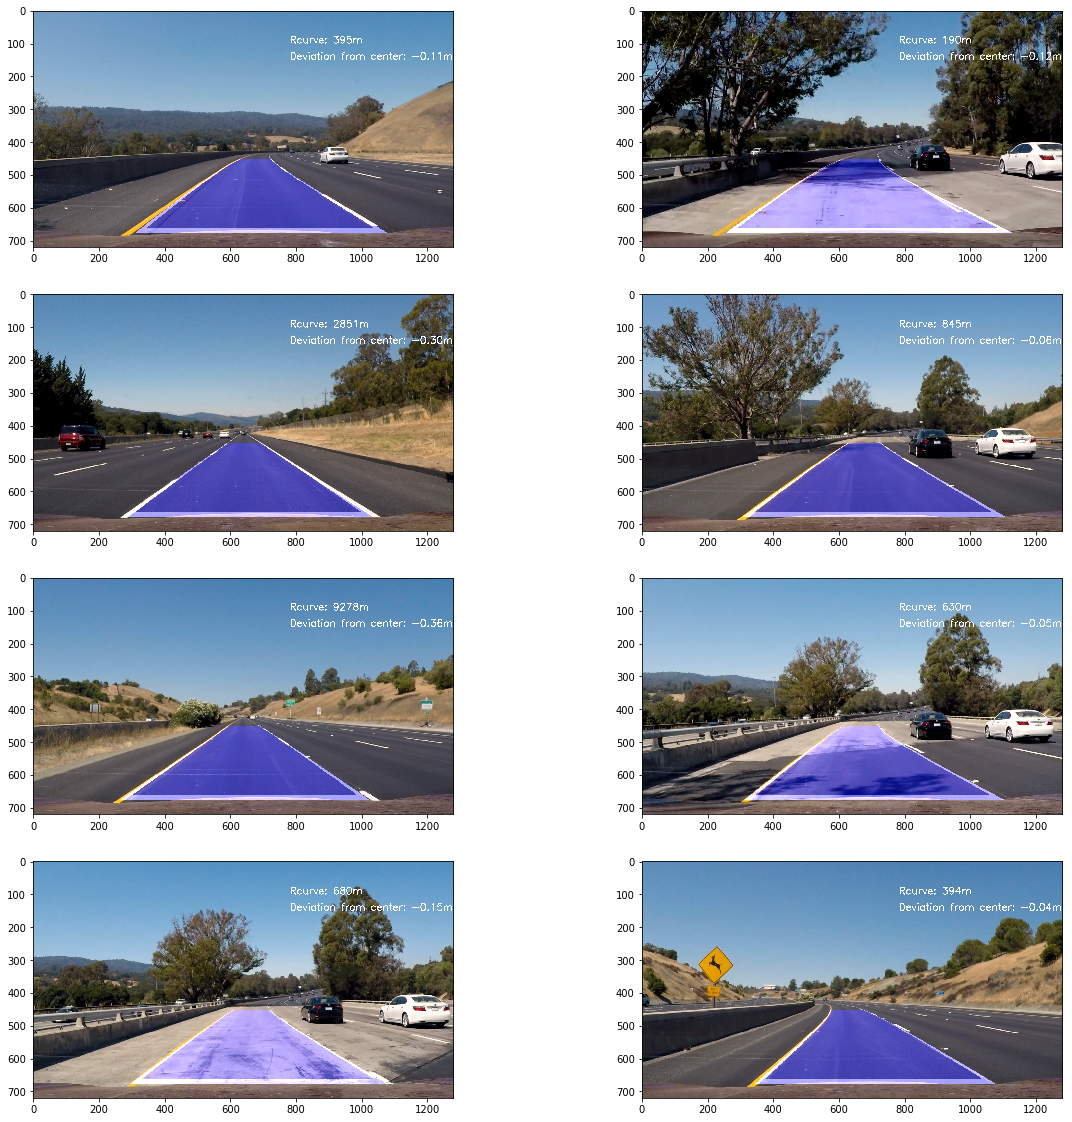

In [302]:
# Code Block 30
lane = Line()
def detect_lane(image):
    global lane
    corrected_image = camera_correction(image)
    binarized_image = image_binarization(corrected_image)
    top_image = birdseye(binarized_image)
    lane = parametrize_lanelines(top_image, lane)
    hud = overlay_mask(image,lane)
    detected_lane = weighted_img(image,hud)
    return detected_lane

# Load the camera parameters
with open("camera.pickle", "rb") as f:
    mtx = pickle.load(f)
    dist = pickle.load(f)

# Test of all the test images
fig = plt.figure(figsize=(20,20))
images = glob.glob("test_images/*.jpg")
i = 0
for fname in images:
    print(fname)
    lane = Line()
    image = mpimg.imread(fname)
    detected_lane = detect_lane(image)
    ax = fig.add_subplot(421+i)
    ax.imshow(detected_lane)
    i += 1
    plt.imshow(detected_lane)

### Now let's find the best lane lines candidates

### Based on the best candidates averages the top best positive and negative slopes are draw

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [191]:
# Code Block 31
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [303]:
# Code Block 32
lane = Line()
white_output = 'project_simon.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detect_lane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_simon.mp4
[MoviePy] Writing video project_simon.mp4


100%|█████████▉| 1260/1261 [05:37<00:00,  3.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_simon.mp4 

CPU times: user 11min 59s, sys: 1.8 s, total: 12min 1s
Wall time: 5min 38s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [198]:
# Code Block 33
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/simonmijares/CarNDT1P4.git) to the project.
